In [9]:
import nibabel as nib
import nilearn
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import re
import pickle as pkl
from plotting_utils_ses_sstmsit import *
import scipy
from scipy.stats import mode
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import math

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
def get_mni_roi_masks_1mm():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))    
    return mask_fns

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns

def get_mni_roi_masks_first20_bin():
    mask_fns = get_mni_roi_masks_first20()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin

## Convert subject-level COPEs to PSC

In [11]:
base_dir = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/subject_level_model'
all_copes = sorted(glob.glob(os.path.join(base_dir, '*','*','func','model-0','sub-*_task-*_space-MNI152NLin2009cAsym_model-0_contrast-*_desc-cope.nii.gz')))
regex = re.compile('.*glm_feat_sst_roi/subject_level_model/(?P<dataset>\S+)/sub-.*/func/model-0/sub-(?P<sub>\S+)_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-(?P<contrast>\d)_desc-cope.nii.gz')

def convert_to_psc(fn):
    gd = regex.match(fn).groupdict()
    dataset, sub, contrast = gd['dataset'], gd['sub'], gd['contrast']
    # convert to PSC
    
    func_data = sorted(glob.glob(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-{sub}/func/sub-{sub}_task-*_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0]
    mean_img = nilearn.image.mean_img(func_data)

    scale_factor = 100*0.0211   # from Jeanette Mumford's instructions
    cope_psc = nilearn.image.math_img(f'nii1*{scale_factor}/nii2', nii1=fn, nii2=mean_img)
    cope_psc.to_filename(fn.replace('.nii.gz', '_psc.nii.gz'))
    
from joblib import Parallel, delayed
_ = Parallel(n_jobs=20)(delayed(convert_to_psc)(fn) for fn in all_copes)

<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: RuntimeWarning: invalid valu

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

'fs': 0,
'ss': 1,
'go': 2,
'fs-go': 3,
'fs-ss': 4,
'ss-go': 5


### Extract subjectwise, ROI-wise COPEs in PSC and save

In [12]:
all_rois = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/MNI152NLin2009cAsym_1mm_label-*.nii.gz'))
ROIS_lr = ['-'.join(x.split('-')[-2:]).split('.')[0] for x in all_rois]
ROIS_lr
masks_bin = get_mni_roi_masks_first20_bin()

masker = nilearn.maskers.NiftiMapsMasker(masks_bin)    # define masker for extraction

In [13]:
all_copes_psc = sorted(glob.glob(os.path.join(base_dir, '*','*','func','model-0','sub-*_task-*_space-MNI152NLin2009cAsym_model-0_contrast-*_desc-cope_psc.nii.gz')))
all_copes_psc_nii = nilearn.image.concat_imgs(all_copes_psc)

In [14]:
out = masker.fit_transform(all_copes_psc_nii)
out = pd.DataFrame(out, columns=ROIS_lr, index=all_copes).reset_index()
out['dataset'] = out['index'].apply(lambda x: x.split('/')[-5])
out['subject'] = out['index'].apply(lambda x: x.split('/')[-4].split('-')[-1])
out = out.melt(id_vars=['index', 'dataset', 'subject'], value_name='cope', var_name='roi')
out['hemisphere'] = out['roi'].apply(lambda x: x.split('-')[-1])
out['roi_nohemi'] = out['roi'].apply(lambda x: x.split('-')[0])
out['contrast'] = out['index'].apply(lambda x: x.split('/')[-1].split('-')[5][0])
out = out[['dataset', 'subject', 'contrast', 'roi', 'hemisphere', 'roi_nohemi', 'cope', 'index']]
out.roi_nohemi = out.roi_nohemi.replace({'m1':'M1','gpe':'GPe','gpi':'GPi','sn':'SN','stn':'STN','str':'Str','tha':'Tha','vta':'VTA', 'preSMA': 'SMA'})
out['ROI'] = out['roi_nohemi'] + '-' + out['hemisphere']
out = out.sort_values(['dataset', 'subject', 'contrast', 'ROI', 'hemisphere'])

contrast_dict = {'0':'fs', '1': 'ss', '2': 'go', '3':'fs-go', '4':'fs-ss', '5':'ss-go'}
out['contrast_name'] = out['contrast'].apply(lambda x: contrast_dict[x])

out.to_csv('/home/scotti/projects/3t_7t_sst_comparison/derivatives/copes_psc_from_feat.tsv',sep='\t')

out.head()

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


,dataset,subject,contrast,roi,hemisphere,roi_nohemi,cope,index,ROI,contrast_name
0,Leipzig_7T_GdH,BI3T,0,Caudate-l,l,Caudate,-0.173401,/home/scotti/projects/3t_7t_sst_comparison/der...,Caudate-l,fs
1044,Leipzig_7T_GdH,BI3T,0,Caudate-r,r,Caudate,-0.221151,/home/scotti/projects/3t_7t_sst_comparison/der...,Caudate-r,fs
6264,Leipzig_7T_GdH,BI3T,0,gpe-l,l,GPe,0.004661,/home/scotti/projects/3t_7t_sst_comparison/der...,GPe-l,fs
7308,Leipzig_7T_GdH,BI3T,0,gpe-r,r,GPe,-0.012540,/home/scotti/projects/3t_7t_sst_comparison/der...,GPe-r,fs
8352,Leipzig_7T_GdH,BI3T,0,gpi-l,l,GPi,-0.182038,/home/scotti/projects/3t_7t_sst_comparison/der...,GPi-l,fs


# Analyze in R

In [18]:
%%R
.libPaths(c(.libPaths(), '/home/stevenm/R/x86_64-pc-linux-gnu-library/4.4'))
library('BayesFactor')
library('lme4')
library('lmerTest')

# load data
dat <- read.table('/home/scotti/projects/3t_7t_sst_comparison/derivatives/copes_psc_from_feat.tsv', sep='\t', header=1)
dat[!dat$dataset=='Leipzig_7T_GdH','subject'] <- as.numeric(dat[!dat$dataset=='Leipzig_7T_GdH','subject'])
dat <- dat[order(dat$dataset, dat$subject, dat$roi_nohemi, dat$hemisphere),]
dat <- dat[,!grepl('index', colnames(dat))]
dat$event.type <- dat$contrast_name

# ensure unique name of all subjects (sub-01 of dataset 2 isn't the same as sub-01 of dataset 3)
dat$sub <- apply( dat[ , c('dataset','subject') ] , 1 , paste , collapse = "-" )
dat$sub <- factor(dat$sub)
dat$subject <- factor(dat$subject)
dat$dataset <- factor(dat$dataset)
dat$hemisphere <- factor(dat$hemisphere)
dat$roi <- factor(dat$roi)
dat$event.type <- factor(dat$event.type)

# output data frame
bfs <- data.frame(expand.grid(contrast=c('fs-go', 'fs-ss', 'ss-go'), roi=unique(dat$roi_nohemi), hemisphere=c('l','r')))
bfs$bf <- NA

for(i in 1:nrow(bfs)) {
  roi = as.character(bfs[i,'roi'])
  hemi = as.character(bfs[i,'hemisphere'])
  contrast_ <- as.character(bfs[i,'contrast'])
  if(contrast_ == 'fs-go') {
    contrast_vals <- c('fs','go')
  } else if(contrast_ == 'fs-ss') {
    contrast_vals <- c('fs','ss')
  } else if(contrast_ == 'ss-go') {
    contrast_vals <- c('ss', 'go')
  }

  bf <- generalTestBF(cope~event.type,
                      whichRandom=c('dataset', 'sub'),
                      data=dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,],
                      rscaleFixed = 0.25)  # small effect size
  bfs[i,'bf'] <- extractBF(bf)$bf
}

write.table(bfs, file='/home/scotti/projects/3t_7t_sst_comparison/derivatives/BFs_roi_analysis_sm.tsv',sep='\t')


# t-values from LME for comparison
tstats <- data.frame(expand.grid(contrast=c('fs-go', 'fs-ss', 'ss-go'), roi=unique(dat$roi_nohemi), hemisphere=c('l','r')))
tstats$t <- NA
tstats$p <- NA

for(i in 1:nrow(tstats)) {
  roi = as.character(tstats[i,'roi'])
  hemi = as.character(tstats[i,'hemisphere'])
  contrast_ <- as.character(tstats[i,'contrast'])
  if(contrast_ == 'fs-go') {
    contrast_vals <- c('fs','go')
    mod <- lmer(cope~relevel(event.type, ref='go')+(1|dataset) + (1|sub), dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,])
  } else if(contrast_ == 'fs-ss') {
    contrast_vals <- c('fs','ss')
    mod <- lmer(cope~relevel(event.type, ref='ss')+(1|dataset) + (1|sub), dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,])
  } else if(contrast_ == 'ss-go') {
    contrast_vals <- c('ss', 'go')
    mod <- lmer(cope~relevel(event.type, ref='go')+(1|dataset) + (1|sub), dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,])
  }
  # mod <- lmer(cope~1+(1|dataset), dat[dat$event.type%in%contrast_&dat$roi_nohemi==roi&dat$hemisphere==hemi,])
  #  dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,]

  tstats[i,'t'] <- summary(mod)$coefficients[2,4]
  tstats[i,'p'] <- summary(mod)$coefficients[2,5]
}
write.table(tstats, file='/home/scotti/projects/3t_7t_sst_comparison/derivatives/tstats_roi_analysis_feat.tsv', sep='\t')

# ## some checks
# head(dat)
# contrast_n <- 0
# par(mfrow=c(3,3))
# for(ROI in unique(dat$ROI)) plot(dat[dat$ROI==ROI&dat$contrast==contrast_n,'cope'], xlab='Subject', ylab='COPE', main=ROI)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



### 1. Bayes Factors

In [19]:
load_bf = pd.read_csv('/home/scotti/projects/3t_7t_sst_comparison/derivatives/BFs_roi_analysis_sm.tsv', sep='\t')
load_bf['full_roi'] = load_bf['roi']+'-'+load_bf['hemisphere']
load_bf['frame_bf'] = np.log10(load_bf['bf']).round(2)
load_bf['full_roi'] = load_bf.full_roi.replace({'SMA-l': 'preSMA-l', 'SMA-r': 'preSMA-r'})
# load_bf['frame_bf'] = load_bf['frame_bf']
load_bf = load_bf.rename(columns={'contrast': 'Contrast'})
load_bf.head()

,Contrast,roi,hemisphere,bf,full_roi,frame_bf
1,fs-go,Caudate,l,59.613799,Caudate-l,1.78
2,fs-ss,Caudate,l,0.781796,Caudate-l,-0.11
3,ss-go,Caudate,l,0.899678,Caudate-l,-0.05
4,fs-go,GPe,l,0.512250,GPe-l,-0.29
5,fs-ss,GPe,l,1.139086,GPe-l,0.06


/tmp/ipykernel_3676001/4195778703.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','BF')


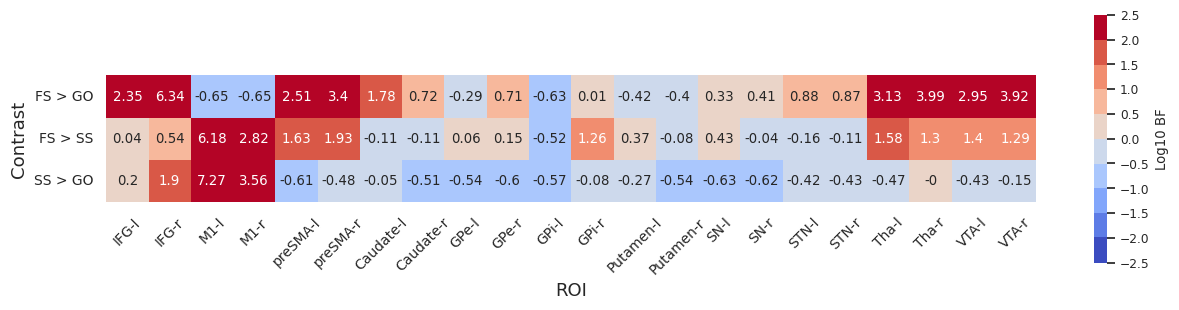

In [22]:
# change some namings in the data
dat = load_bf.rename(columns={'frame_c':'Contrast','full_roi':'ROI','frame_bf':'BF'})
dat.replace({'fs-go':'FS > GO', 'fs-ss':'FS > SS','ss-go':'SS > GO'}, inplace=True)
# threshs = dat.pivot('Contrast','ROI','fdr_thresh')
dat = dat.pivot('Contrast','ROI','BF')

roi_ordered = ['IFG-l','IFG-r','M1-l','M1-r','preSMA-l','preSMA-r','Caudate-l','Caudate-r','GPe-l','GPe-r','GPi-l','GPi-r','Putamen-l','Putamen-r',
               'SN-l','SN-r','STN-l','STN-r','Tha-l','Tha-r','VTA-l','VTA-r']
dat = dat.reindex(columns=roi_ordered)

f = plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k', )
sns.set(font_scale=0.8)

cmap_load = matplotlib.cm.get_cmap('coolwarm')
bounds = np.linspace(0,1,10)
all_colours = [cmap_load(x) for x in bounds]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', all_colours, len(all_colours))

g = sns.heatmap(dat, annot=True, center = 0,cmap = cmap, square = True, fmt='.3g', vmin=-2.5,vmax=2.5,cbar_kws={"shrink": .46, "ticks":[-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5],'label': 'Log10 BF'})
# gg = sns.heatmap(dat, mask=dat_mask, cmap=plt.get_cmap('binary'),vmin=2,vmax=2, cbar=False)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
g.set_xlabel('ROI', fontsize=13)
g.set_ylabel('Contrast',fontsize=13)

f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

### 2. T-stats

In [23]:
## SM's t-statistics
load_bf = pd.read_csv('/home/scotti/projects/3t_7t_sst_comparison/derivatives/tstats_roi_analysis_feat.tsv', sep='\t')
load_bf['full_roi'] = load_bf['roi']+'-'+load_bf['hemisphere']
load_bf['full_roi'] = load_bf.full_roi.replace({'SMA-l': 'preSMA-l', 'SMA-r': 'preSMA-r'})
load_bf = load_bf.rename(columns={'contrast': 'Contrast'})
load_bf['p_fdr'] = load_bf.groupby('Contrast')['p'].transform(lambda x: statsmodels.stats.multitest.fdrcorrection(x, method='i')[1])

/tmp/ipykernel_3676001/1671596557.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pvals = dat.pivot('Contrast','ROI','p_fdr')
/tmp/ipykernel_3676001/1671596557.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','t')


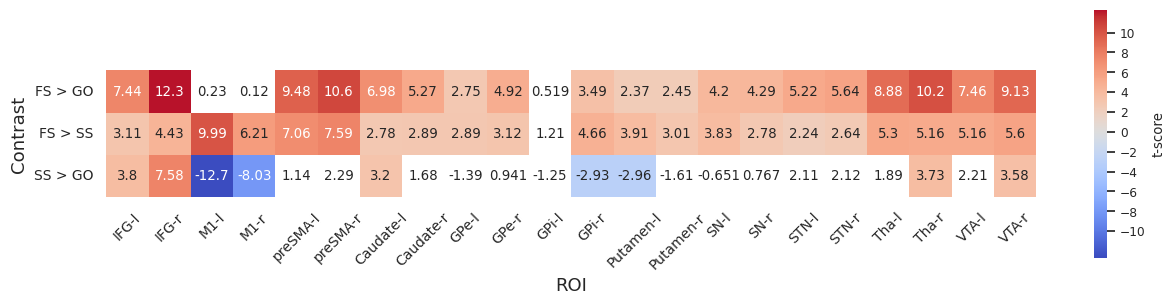

In [24]:
# change some namings in the data
dat = load_bf.rename(columns={'contrast':'Contrast','full_roi':'ROI'})
dat.replace({'fs-go':'FS > GO', 'fs-ss':'FS > SS','ss-go':'SS > GO'}, inplace=True)
pvals = dat.pivot('Contrast','ROI','p_fdr')
dat = dat.pivot('Contrast','ROI','t')

roi_ordered = ['IFG-l','IFG-r','M1-l','M1-r','preSMA-l','preSMA-r','Caudate-l','Caudate-r','GPe-l','GPe-r','GPi-l','GPi-r','Putamen-l','Putamen-r',
               'SN-l','SN-r','STN-l','STN-r','Tha-l','Tha-r','VTA-l','VTA-r']
dat = dat.reindex(columns=roi_ordered)
pvals = pvals.reindex(columns=roi_ordered)
p_mask = (pvals < 0.05)

f = plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k', )
sns.set(font_scale=0.8)

g = sns.heatmap(dat, annot=True, center = 0,cmap = 'coolwarm', square = True, fmt='.3g', cbar_kws={"shrink": .46, "ticks":[-10,-8,-6,-4,-2,0,2,4,6,8,10], 'label': 't-score'})
gg = sns.heatmap(dat, mask=p_mask, cmap=plt.get_cmap('binary'),vmin=2,vmax=2, cbar=False)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
g.set_xlabel('ROI', fontsize=13)
g.set_ylabel('Contrast',fontsize=13)

f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_tvals_group-level_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_tvals_group-level_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_tvals_group-level_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# Lee and Wagenmakers 2014 BF scale

In [ ]:
1 to 3	Anecdotal
3 to 10	Moderate
10 to 30	Strong
30 to 100	Very strong
> 100	Extreme

1 to 0.3 -> Anecdotal
0.1 to 0.1 -> Moderate
0.1 to 0.03 -> Strong
0.03 to 0.01 -> Very strong
< 0.01 -> Extreme



In log:
0 to 0.5
0.5 to 1
1 to 1.5
1.5 to 2
> 2

0 to -0.5
-0.5 to -1
-1 to -1.5
-1.5 to -2
< -2


In [ ]:
	0 to 1/2	Barely worth mentioning
101/2 to 10	1/2 to 1	Substantial
10 to 103/2	1 to 3/2	Strong
103/2 to 102	3/2 to 2	Very strong
> 102	> 2

## Medium effect size?


In [25]:
%%R
.libPaths(c(.libPaths(), '/home/stevenm/R/x86_64-pc-linux-gnu-library/4.4'))
library('BayesFactor')
library('lme4')
library('lmerTest')

# load data
dat <- read.table('/home/scotti/projects/3t_7t_sst_comparison/derivatives/copes_psc_from_feat.tsv', sep='\t', header=1)
dat[!dat$dataset=='Leipzig_7T_GdH','subject'] <- as.numeric(dat[!dat$dataset=='Leipzig_7T_GdH','subject'])
dat <- dat[order(dat$dataset, dat$subject, dat$roi_nohemi, dat$hemisphere),]
dat <- dat[,!grepl('index', colnames(dat))]
dat$event.type <- dat$contrast_name

# ensure unique name of all subjects (sub-01 of dataset 2 isn't the same as sub-01 of dataset 3)
dat$sub <- apply( dat[ , c('dataset','subject') ] , 1 , paste , collapse = "-" )
dat$sub <- factor(dat$sub)
dat$subject <- factor(dat$subject)
dat$dataset <- factor(dat$dataset)
dat$hemisphere <- factor(dat$hemisphere)
dat$roi <- factor(dat$roi)
dat$event.type <- factor(dat$event.type)

# output data frame
bfs <- data.frame(expand.grid(contrast=c('fs-go', 'fs-ss', 'ss-go'), roi=unique(dat$roi_nohemi), hemisphere=c('l','r')))
bfs$bf <- NA

for(i in 1:nrow(bfs)) {
  roi = as.character(bfs[i,'roi'])
  hemi = as.character(bfs[i,'hemisphere'])
  contrast_ <- as.character(bfs[i,'contrast'])
  if(contrast_ == 'fs-go') {
    contrast_vals <- c('fs','go')
  } else if(contrast_ == 'fs-ss') {
    contrast_vals <- c('fs','ss')
  } else if(contrast_ == 'ss-go') {
    contrast_vals <- c('ss', 'go')
  }

  bf <- generalTestBF(cope~event.type,
                      whichRandom=c('dataset', 'sub'),
                      data=dat[dat$event.type%in%contrast_vals&dat$roi_nohemi==roi&dat$hemisphere==hemi,],
                      rscaleFixed = 0.5)  # medium effect size -- default
  bfs[i,'bf'] <- extractBF(bf)$bf
}

write.table(bfs, file='/home/scotti/projects/3t_7t_sst_comparison/derivatives/BFs_roi_analysis_sm_reffp5.tsv',sep='\t')


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [26]:
load_bf = pd.read_csv('/home/scotti/projects/3t_7t_sst_comparison/derivatives/BFs_roi_analysis_sm_reffp5.tsv', sep='\t')
load_bf['full_roi'] = load_bf['roi']+'-'+load_bf['hemisphere']
load_bf['frame_bf'] = np.log10(load_bf['bf']).round(2)
load_bf['full_roi'] = load_bf.full_roi.replace({'SMA-l': 'preSMA-l', 'SMA-r': 'preSMA-r'})
# load_bf['frame_bf'] = load_bf['frame_bf']
load_bf = load_bf.rename(columns={'contrast': 'Contrast'})
load_bf.head()

,Contrast,roi,hemisphere,bf,full_roi,frame_bf
1,fs-go,Caudate,l,47.760449,Caudate-l,1.68
2,fs-ss,Caudate,l,0.465356,Caudate-l,-0.33
3,ss-go,Caudate,l,0.542122,Caudate-l,-0.27
4,fs-go,GPe,l,0.293480,GPe-l,-0.53
5,fs-ss,GPe,l,0.700310,GPe-l,-0.15


/tmp/ipykernel_3676001/3439875719.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','BF')


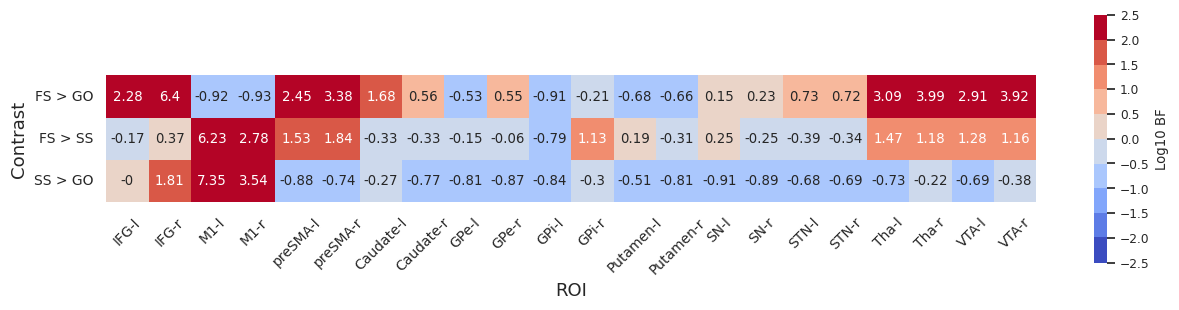

In [28]:
# change some namings in the data
dat = load_bf.rename(columns={'frame_c':'Contrast','full_roi':'ROI','frame_bf':'BF'})
dat.replace({'fs-go':'FS > GO', 'fs-ss':'FS > SS','ss-go':'SS > GO'}, inplace=True)
# threshs = dat.pivot('Contrast','ROI','fdr_thresh')
dat = dat.pivot('Contrast','ROI','BF')

roi_ordered = ['IFG-l','IFG-r','M1-l','M1-r','preSMA-l','preSMA-r','Caudate-l','Caudate-r','GPe-l','GPe-r','GPi-l','GPi-r','Putamen-l','Putamen-r',
               'SN-l','SN-r','STN-l','STN-r','Tha-l','Tha-r','VTA-l','VTA-r']
dat = dat.reindex(columns=roi_ordered)

f = plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k', )
sns.set(font_scale=0.8)

cmap_load = matplotlib.cm.get_cmap('coolwarm')
bounds = np.linspace(0,1,10)
all_colours = [cmap_load(x) for x in bounds]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', all_colours, len(all_colours))

g = sns.heatmap(dat, annot=True, center = 0,cmap = cmap, square = True, fmt='.3g', vmin=-2.5,vmax=2.5,cbar_kws={"shrink": .46, "ticks":[-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5],'label': 'Log10 BF'})
# gg = sns.heatmap(dat, mask=dat_mask, cmap=plt.get_cmap('binary'),vmin=2,vmax=2, cbar=False)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
g.set_xlabel('ROI', fontsize=13)
g.set_ylabel('Contrast',fontsize=13)

f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm_reffp5.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm_reffp5.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_heatmap_BFs_group-level_sm_reffp5.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})